In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
import joblib
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, log_loss, roc_auc_score, classification_report, accuracy_score, recall_score, precision_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import unicodedata
import re
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from sklearn.base import TransformerMixin, BaseEstimator
import shap
import networkx as nx
from sentence_transformers import SentenceTransformer
from sklearn.utils.class_weight import compute_class_weight
import os
import sys


nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

##Data Downloading

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
sys.path.append('/content/drive/MyDrive/ML/Final Project Quora')

In [ ]:
train = pd.read_csv('drive/MyDrive/ML/Final Project Quora/quora_question_pairs_train.csv.zip', index_col=0)
test = pd.read_csv('drive/MyDrive/ML/Final Project Quora/quora_question_pairs_test.csv.zip', index_col=0)

In [ ]:
from text_features import DataTransformer, FeatureCreation

##XGBoost Model

###Creating pipeline

In [ ]:
train_copy = train.dropna()
test_copy = test.dropna()

X_train = train_copy.drop('is_duplicate', axis=1)
y_train = train_copy['is_duplicate']

X_test = test_copy.drop('is_duplicate', axis=1)
y_test = test_copy['is_duplicate']

In [ ]:
pipeline_2 = Pipeline([
    ('textprocess', DataTransformer()),
    ('feature_creation', FeatureCreation()),
    ('model', XGBClassifier(
    eval_metric='logloss',
    n_estimators=100,
    max_depth = 6,
    use_label_encoder=False,
    scale_pos_weight=1.86,
    random_state=42))
])

###Model Evaluation

In [ ]:
def evaluate_model(pipeline, X_test_data, y_test_data, model):
  """
  Evaluates a trained classification pipeline on test data using common metrics.
  """

  y_proba = pipeline.predict_proba(X_test)[:,1]
  y_preds = pipeline.predict(X_test)
  metrics = {
      'model': model,
      'f1_score': f1_score(y_test_data, y_preds),
      'log_loss': log_loss(y_test_data, y_proba)
  }
  return metrics

In [ ]:
results=[]
pipeline_2.fit(X_train,y_train)

results.append(evaluate_model(pipeline=pipeline_2, X_test_data=X_test, y_test_data=y_test, model='XGBoost_model_v1'))

In [ ]:
joblib.dump(pipeline_2, 'drive/MyDrive/ML/Final Project Quora/pipeline_XGBoost_v1.pkl')

['drive/MyDrive/ML/Final Project Quora/pipeline_XGBoost_v1.pkl']

In [ ]:
res=pd.DataFrame(results)
res

model  f1_score  log_loss
0  XGBoost_model_v1  0.739945  0.448747

##Finetuning XGBoost model

###Adding new features

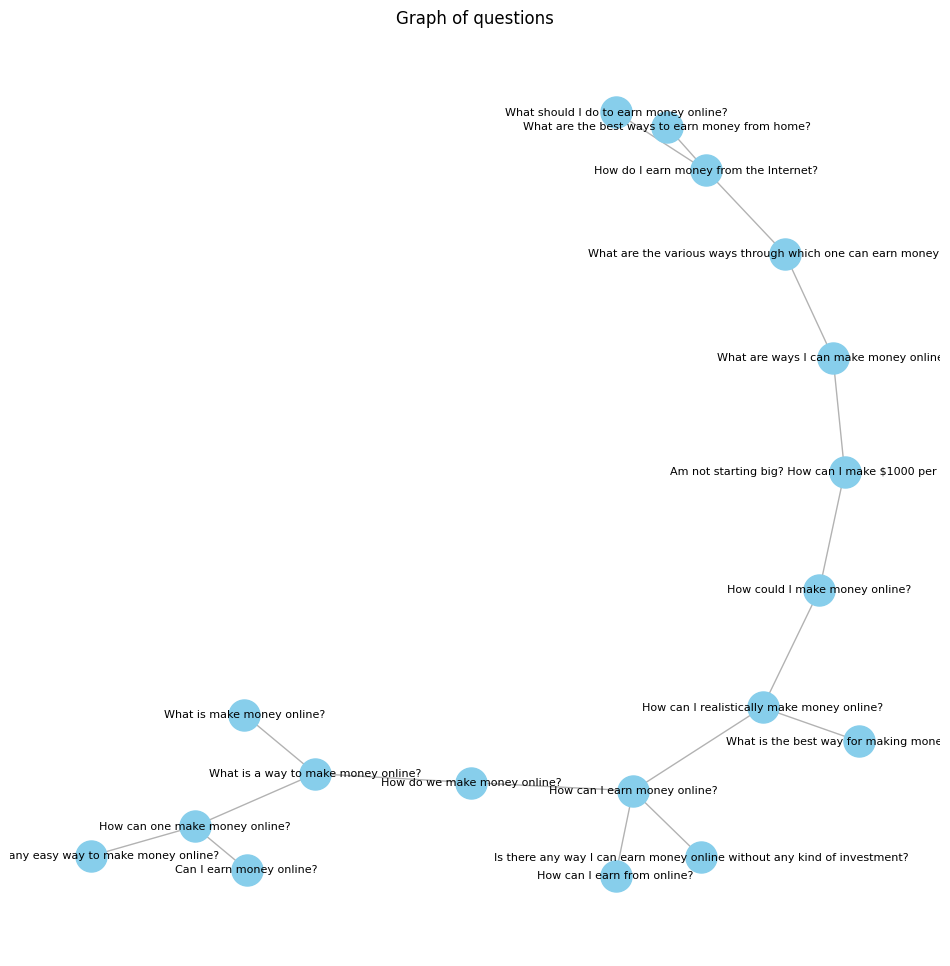

In [ ]:
G = nx.Graph()

#create the graph
sample = X_train.head(10000)
for q1, q2 in zip(sample['question1'], sample['question2']):
    G.add_edge(q1, q2)

#the most connected graph
largest_cc = max(nx.connected_components(G), key=len)
G_sub = G.subgraph(largest_cc).copy()

#plot graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_sub, seed=42)

#nodes
nx.draw_networkx_nodes(G_sub, pos, node_size=500, node_color='skyblue')

#edges
nx.draw_networkx_edges(G_sub, pos, alpha=0.3)
nx.draw_networkx_labels(G_sub, pos, font_size=8)

plt.title("Graph of questions")
plt.axis('off')
plt.show()

Visualization of the largest connected component of question pairs. Each node represents a unique question, and edges connect questions that appeared together in the dataset.

In [ ]:
class GraphFeatures(BaseEstimator, TransformerMixin):
  """
  Transformer that extracts graph-based features from question pairs.

  It builds an undirected graph where each question is a node and each
  pair is an edge. It then computes:
  -Degree of each question node (number of connections).
  """

  def __init__(self):
      self.G = nx.Graph()
      self.degree_map = {}
      self.common_neighbors_map = {}

  def fit(self, X, y=None):
      for q1, q2 in zip(X['question1'], X['question2']):
          self.G.add_edge(q1, q2)
      self.degree_map = dict(self.G.degree)

      return self

  def transform(self, X, y=None):
      X = X.copy()
      X['q1_degree'] = X['question1'].map(lambda q: self.degree_map.get(q, 0))
      X['q2_degree'] = X['question2'].map(lambda q: self.degree_map.get(q, 0))

      return X[['q1_degree', 'q2_degree']]



In [ ]:
class FeatureUnionDF(FeatureUnion):
  """
    A custom extension of sklearn's FeatureUnion that returns a concatenated DataFrame
    if all individual transformer outputs are DataFrames.
  """
  def transform(self, X):
    Xs = [transformer.transform(X) for _, transformer in self.transformer_list]
    if all(isinstance(x, pd.DataFrame) for x in Xs):
      return pd.concat(Xs, axis=1)
    return super().transform(X)


###Train the model based on new features

In [ ]:
pipeline_3 = Pipeline([
    ('textprocess', DataTransformer()),
    ('features', FeatureUnionDF([
        ('nlp_features', FeatureCreation()),
        ('graph_feats', GraphFeatures())
    ])),
    ('model', XGBClassifier(
    eval_metric='logloss',
    n_estimators=100,
    max_depth = 6,
    use_label_encoder=False,
    scale_pos_weight=1.86,
    random_state=42))
])

###Model Evaluation

In [ ]:
pipeline_3.fit(X_train,y_train)

results.append(evaluate_model(pipeline=pipeline_3, X_test_data=X_test, y_test_data=y_test, model='XGBoost_model_v2'))

In [ ]:
res = pd.DataFrame(results)
res

model  f1_score  log_loss
0  XGBoost_model_v1  0.739945  0.448747
1  XGBoost_model_v2  0.786074  0.341203

In [ ]:
joblib.dump(pipeline_2, 'drive/MyDrive/ML/Final Project Quora/pipeline_XGBoost_v2.pkl')

['drive/MyDrive/ML/Final Project Quora/pipeline_XGBoost_v2.pkl']

After adding the new graph features it is evident that XGBoost model version 2 is much better than the version 1.

It has a higher F1-score (0.78 vs 0.74): better balance of precision and recall, i.e., it's more accurate on both duplicates and non-duplicates.

It has a lower log loss (0.34 vs 0.44): its predicted probabilities are better calibrated, meaning it's more confident when it's right and less overconfident when wrong.

###Finetuning hyperparameters of XGBoost model

In [ ]:
def extract_features_from_pipeline(pipeline, X):
    X_processed = pipeline.named_steps['textprocess'].transform(X)
    X_transformed = pipeline.named_steps['features'].transform(X_processed)
    return X_transformed

In [ ]:
X_transformed_train = extract_features_from_pipeline(pipeline_3, X_train)
X_transformed_test = extract_features_from_pipeline(pipeline_3, X_test)

In [ ]:
space = {
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'n_estimators': hp.quniform('n_estimators', 100, 500, 10),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'gamma': hp.uniform('gamma', 0, 1),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 3)
}


In [ ]:
best_auc = [0]

def objective(params):
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])

    model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        early_stopping_rounds=10,
        random_state=42,
        n_jobs=-1,
        **params
    )

    model.fit(X_transformed_train, y_train,
        eval_set=[(X_transformed_test, y_test)],
        verbose=False)

    y_proba = model.predict_proba(X_transformed_test)[:,1]

    auc = roc_auc_score(y_test, y_proba)

    if auc > best_auc[0]:
        best_auc[0] = auc
        joblib.dump(model, 'best_xgb_model_auc.pkl')

    return {'loss': -auc, 'status': STATUS_OK}

In [ ]:
trials = Trials()

best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials
)
print("Best parameters: ", best)
print(f"Best AUROC: {best_auc[0]:.2f}")

In [ ]:
final_clf = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_estimators=int(best['n_estimators']),
    learning_rate=best['learning_rate'],
    min_child_weight =  int(best['min_child_weight']),
    max_depth=int(best['max_depth']),
    subsample=best['subsample'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    scale_pos_weight=best['scale_pos_weight'],
    device='cuda'
)

final_clf.fit(X_transformed_train, y_train)

final_pred_train = final_clf.predict_proba(X_transformed_train)[:,1]
final_pred_test = final_clf.predict_proba(X_transformed_test)[:,1]

final_preds_train = final_clf.predict(X_transformed_train)
final_preds_test = final_clf.predict(X_transformed_test)

###Evaluation of final model

In [ ]:
loss_train = log_loss(y_train, final_pred_train)
print(f"Loss for training data: {loss_train:.2f}")
loss_test = log_loss(y_test, final_pred_test)
print(f"Loss for testing data: {loss_test:.2f}")

Loss for training data: 0.31
Loss for testing data: 0.35


In [ ]:
f1_train = f1_score(y_train, final_preds_train)
print(f"F1 score for training data: {f1_train:.2f}")
f1_test =  f1_score(y_test, final_preds_test)
print(f"F1 score for testing data: {f1_test:.2f}")

F1 score for training data: 0.82
F1 score for testing data: 0.79


In [ ]:
results_xgboost = {'model': 'XGBoost_model_v3',
                   'f1_score': f1_test,
                   'log_loss': loss_test}
results.append(results_xgboost)
results

[{'model': 'XGBoost_model_v1',
  'f1_score': 0.7399446481504895,
  'log_loss': 0.44874730730836115},
 {'model': 'XGBoost_model_v2',
  'f1_score': 0.7860737458458616,
  'log_loss': 0.3412026263380773},
 {'model': 'XGBoost_model_v3',
  'f1_score': 0.7875452793834297,
  'log_loss': 0.34544757975057483}]

In [ ]:
res = pd.DataFrame(results)
file_path = 'drive/MyDrive/ML/Final Project Quora/model_results.csv'

if not os.path.exists(file_path):
  res.to_csv(file_path, index=False)
else:
  res.to_csv(file_path, mode='a', index=False, header=False)

###SHAP Report

In [ ]:
sample_data = X_transformed_train.sample(n=10000, random_state=42)

explainer = shap.TreeExplainer(final_clf)
shap_values = explainer.shap_values(sample_data)

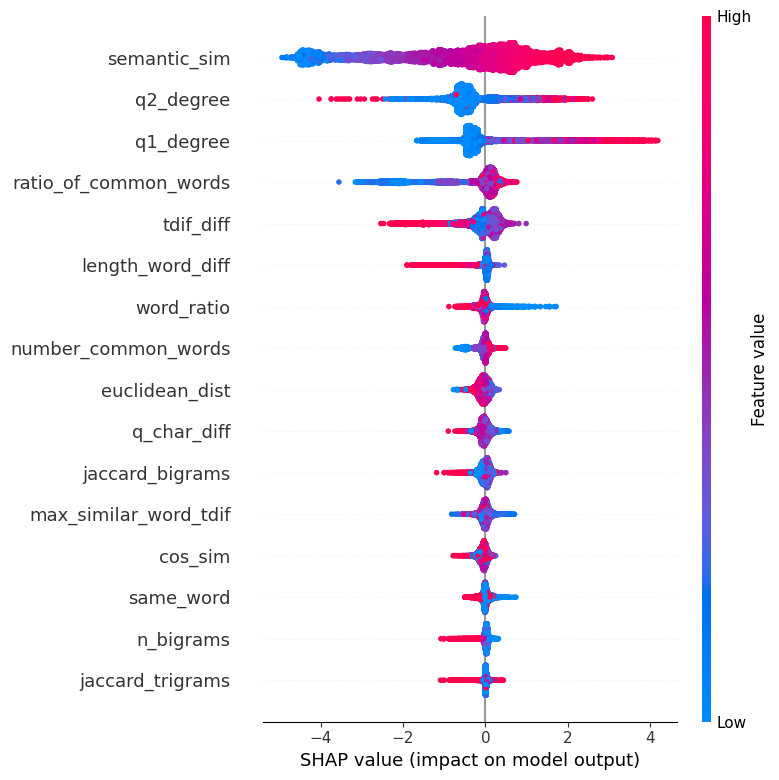

In [ ]:
feature_names = sample_data.columns if hasattr(sample_data, 'columns') else [f'feature_{i}' for i in range(sample_data.shape[1])]
shap.summary_plot(shap_values, sample_data, feature_names=feature_names)

According to the SHAP report 'semantic_sim' is the most important feature: higher similarity (red dots on the right) shows the strong positive impact (suggests duplicate). Lower similarity (blue dots on the left ) - negative impact (suggests not duplicate).

'q1_degree' and 'q2_degree' - higher degrees (red) tend to reduce the probability of duplication.

'ratio_of_common_words' - when the ratio of common words is high, it contributes positively.

'tdif_diff', 'length_word_diff' - a big difference between tdif vectors and in word count contributes negatively.

'jaccard_bigrams', 'cos_sim', 'number_of_common_words' - higher values push the prediction towards duplicates.